<img src="img/saclay_center.png" width="800" height="600">

<center> <font color="blue"><h2>  Datacamp Challenge : Prediction of daily transport validation in Paris public underground transports </h2> </center>

<center> <h4> Authors :Dina ABED , Siwar ABBES, Philippe DE SAINT CHAMAS, Mohamed Skander HELLAL, Gwendal HENGOAT, Jules ZACCARDI </h4> </center>

<img src="img/sncf.jpg" width="600" height="600">

### Table of contents
1. [Business Case](#Businesscase)
2. [Libraries to install](#Libraries)
3. [Data for the challenge](#Data)
4. [Exploratory Data analysis](#Data-exploration)
5. [Prediction](#Prediction)
6. [Evaluation](#Evaluation)
7. [Local testing](#Local-testing)

<a id='Businesscase'></a>
## 1. Business Case

### 1.1.Introduction

Since 2017, the Autonomous Parisian Transportation Administration (aka RATP in french) has chosen to associate itself with a comprehensive Open Data approach, which the French government has initiated with its Etalab mission, along with certain other local governments and administrations, by making some of its data accessible and usable by all. 
In this perspective, many databases are accessible online by anyone here : https://dataratp.opendatasoft.com/explore/?sort=modified. 

The goal of this challenge is to work with open data. There is a lot to do in exploiting public data and building machine learning models to improve public services. In large metropolis, there are many sources of public data which can easily made available through data collection protocols and powerful APIs. 

In Paris urban area, today almost 3 billion validation in the metro systems are counted each year and this number is continuously increasing. Handling public transports in an optimal way is one of the most important challenges for a city as global and evolving as Paris. As the city is growing and modernising, more and more suburban areas need to be connected with transports. It is our responsibility to work on improving it.  

### 1.2.Business problem

Public transports face a great deal of issues. One of them is the management of the stations. There is a need of staff to open and close the station and to help travellers (to provide indications, secure the platforms and help travellers). There is a possibility of opening stores in the metro station and putting public toilets in it. 

Knowing how many people come into a given metro station each day, RATP can affect the appriopriate amount of staff, it can decide to open new toilets and to sell spots to stores. 

Thus, this problem has general utility, but it is also powerful to solve intermittent issues. During a strike as instance, RATP has to decide how to deploy its reduced workforce in an optimal way.


### 1.3.Challenge aim

This challenge is a regression task which aims at predicting the number of validation in a metro station per day. 

This is a limited scope problem.
Indeed, our data only includes the "Pass Navigo" validations, which is the season ticket of the transport net. 
First, it is a limited information on the behaviour of the users as we do not know where they have connections, neither where they exit. 
Furthermore, we don't have any information about the single use tickets validations. Intuitively, it is far from negligible as two population categories in Paris among others are concerned: tourists and working persons from other cities or other countries. They represent a massive amount of persons and there is no reason why they should have the same behaviour as the persons taken into acount in our data.

We consider that our problem gives an idea anyway of the frequentation of the stations.

#### 1.4.Business Metric

For this challenge we shall use the **Log-Cosh Loss**.
It is defined as follows:
$$ L(y,y^p) = \sum_{i = 1}^n log(cosh(y_i^p-y_i)). $$

It is close to $x^2/2$ for small values and $|x|-log(2)$ for large values. 

It works like the mean squared error but is robust to outlayers with larges values. It has the advantage on the Huber loss (which is a mean squared error for small values and a mean absolute error above a certain bound) that it is twice derivable which can be useful for some regression methods. 

<a id='Libraries'></a>
## 2.Libraries to install

This starting kit requires the following libraries:

* `numpy`
* `pandas`
* `seaborn`
* `scikit-learn`
* `matplolib`
* `folium`
* `calendar`
* `datetime`
* `IPythhon`

We recommand you to install these libraries using `conda` (using the [`Anaconda`](https://www.anaconda.com/distribution/) distribution).

For this challenge, `ramp-workflow` is also needed. This can be installed from the master branch on GitHub:

      python -m pip install https://api.github.com/repos/paris-saclay-cds/ramp-workflow/zipball/master

<a id='Data'></a>
## 3 . Data for the challenge

### Import Libraries

In [12]:
import sys
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import folium
import pandas as pd
import calendar

from datetime import timedelta, date
from IPython.display import display
from folium import Popup

%matplotlib inline
sns.set_style('ticks')
sns.set(rc={'figure.figsize':(13.7,9.27)})
warnings.filterwarnings('ignore')

### Loading the Data

In [13]:
# Load train data
#X_train.shape , y_train.shape
X_train = pd.read_csv('data/data challenge/data_challenge_TRAIN.csv')

#### 3.1 Basic data exploited
The Basic data used are in our challenge are the open data available on the Ile-de-France Mobilités platform which provides validation data of the entire Ile-de-France network. The transport network seen by the validation data covers 725 train stops (RER, metro, Transilien). 
Source: https://data.iledefrance-mobilites.fr/explore/dataset/histo-validations/information/

We have merged all the data availabble since the first semester of 2015 until 2019. To get a whole observations of the number of validations per day and per stop. 

#### 3.2 Adding more features to ou basic data
Thinking about some informations that could impact the frequentation of stations, our brainstorming leads to try to find other databases that contain these significant features to our business model:

- find to which metro/RER line corresponds each stop, Database exploited: https://data.iledefrance-mobilites.fr/explore/dataset/emplacement-des-gares-idf-data-generalisee/information/
- Search for a database of public holidays (whether public holiday or not and if so, the type of this day: Weekend, Christmas, Toussaint,...), Database exploited: https://www.data.gouv.fr/fr/datasets/jours-feries-en-france/
- Incident rate, incident data on all RATP lines per day, Database exploited: http://data.cquest.org/openeventdatabase/
- Social movements, Data on SNCF social movements: https://ressources.data.sncf.com/explore/dataset/mouvements-sociaux-depuis-2002/table/?sort=date_de_debut
- Referential of passenger stations, Database: https://data.sncf.com/explore/dataset/frequentation-gares/table/?sort=nom_gare



The dataset provided was built using the RATP open data, by merging many these different datasets. Each row gives the following information for one station at one day : 

* `JOUR`
* `LIBELLE_ARRET` : name of the station
* `NB_VALD` : total number of validation at this station for the day 
* `lon` : longitude of the station
* `lat` : latitude
* `res_com` : list of lines at this station
* `mode_` : list of types of lines at this station
* `principal`
* `nb_rer` : number of RER at this station
* `nb_metro` : number of metros at this station
* `Nbre plateformes` : number 
* `duree` : total duration of incidents this day on the lines going through the station
* `type_inc` : type of incidents this day on the lines going through the station 
* `num_inc` : total number of incidents this day on the lines going through the station 
* `est_grev` : boolean indicating if this day is a strike or not 
* `Jour de la semaine` : day of the week 
* `Horaire en jour normal` 
* `Horaire en jour ferié`
* `est_jour_ferie`
* `type_jour`

In [30]:
#X_train.head() (A faire quand problem.py sere prêt)
# Provisoirement avec toute la data:
X_train.head()

,JOUR,LIBELLE_ARRET,NB_VALD,lon,lat,res_com,mode_,principal,nb_metro,nb_rer,...,Nbre plateformes,duree,type_inc,num_inc,est_greve,Jour de la semaine,Horaire en jour normal,Horaire en jour férié,est_jour_ferie,type_jour
0,2015-01-01,ABBESSES,750,48.884505,2.338365,M12,Metro,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,0.0,Thursday,NaN,NaN,1,Jour de l'an
1,2015-01-01,ABLON,118,NaN,NaN,RER C,RER,0.0,0.0,1.0,...,1.0,NaN,NaN,NaN,0.0,Thursday,NaN,NaN,1,Jour de l'an
2,2015-01-01,ACHERES-GRAND-CORMIER,18,48.955388,2.092457,RER A,RER,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,0.0,Thursday,NaN,NaN,1,Jour de l'an
3,2015-01-01,ACHERES-VILLE,482,48.970248,2.077672,LIGNE L / RER A,Train / RER,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,0.0,Thursday,NaN,NaN,1,Jour de l'an
4,2015-01-01,AEROPORT CHARLES DE GAULLE 1,1257,49.010400,2.561357,RER B / CDGVAL,RER / Navette,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,0.0,Thursday,NaN,NaN,1,Jour de l'an


The data is composed of x features and y observations.Each observation corresponds to + explication des features ....

In [31]:
# X_train.describe()
X_train.describe()

,NB_VALD,lon,lat,principal,nb_metro,nb_rer,Nbre plateformes,num_inc,est_greve,est_jour_ferie
count,1.143448e+06,655719.000000,655719.000000,1.111160e+06,1.115448e+06,1.115448e+06,276449.0,141443.000000,1.143448e+06,1.143448e+06
mean,7.825481e+03,48.859416,2.343570,1.046105e-01,7.294352e-01,3.505300e-01,1.0,7.277737,1.976697e-01,3.063279e-02
std,1.393899e+04,0.045931,0.088400,3.060510e-01,9.659806e-01,5.172399e-01,0.0,20.097831,3.982418e-01,1.723208e-01
min,5.000000e+00,48.695061,2.012258,0.000000e+00,0.000000e+00,0.000000e+00,1.0,1.000000,0.000000e+00,0.000000e+00
25%,7.860000e+02,48.843076,2.305558,0.000000e+00,0.000000e+00,0.000000e+00,1.0,1.000000,0.000000e+00,0.000000e+00
50%,4.008000e+03,48.861193,2.346203,0.000000e+00,0.000000e+00,0.000000e+00,1.0,2.000000,0.000000e+00,0.000000e+00
75%,9.483000e+03,48.880790,2.385203,0.000000e+00,1.000000e+00,1.000000e+00,1.0,5.000000,0.000000e+00,0.000000e+00
max,2.190510e+05,49.049765,2.773608,1.000000e+00,5.000000e+00,3.000000e+00,1.0,356.000000,1.000000e+00,1.000000e+00


In [50]:
X_train.groupby('LIBELLE_ARRET')['NB_VALD'].mean().to_clipboard()

In [32]:
X_train.isna().sum() / X_train.shape[0]

JOUR                      0.000000
LIBELLE_ARRET             0.000000
NB_VALD                   0.000000
lon                       0.426542
lat                       0.426542
res_com                   0.028237
mode_                     0.028237
principal                 0.028237
nb_metro                  0.024487
nb_rer                    0.024487
line                      0.569663
Segment DRG               0.759345
Nbre plateformes          0.758232
duree                     0.876301
type_inc                  0.876301
num_inc                   0.876301
est_greve                 0.000000
Jour de la semaine        0.000000
Horaire en jour normal    0.975509
Horaire en jour férié     0.977227
est_jour_ferie            0.000000
type_jour                 0.000000
dtype: float64

In [33]:
X_train.nunique()

JOUR                       1458
LIBELLE_ARRET               735
NB_VALD                   44127
lon                         385
lat                         385
res_com                     140
mode_                        15
principal                     2
nb_metro                      6
nb_rer                        4
line                         18
Segment DRG                   3
Nbre plateformes              1
duree                       591
type_inc                     11
num_inc                     122
est_greve                     2
Jour de la semaine            7
Horaire en jour normal       27
Horaire en jour férié        14
est_jour_ferie                2
type_jour                    13
dtype: int64

In [34]:
X_train.dtypes

JOUR                       object
LIBELLE_ARRET              object
NB_VALD                     int64
lon                       float64
lat                       float64
res_com                    object
mode_                      object
principal                 float64
nb_metro                  float64
nb_rer                    float64
line                       object
Segment DRG                object
Nbre plateformes          float64
duree                      object
type_inc                   object
num_inc                   float64
est_greve                 float64
Jour de la semaine         object
Horaire en jour normal     object
Horaire en jour férié      object
est_jour_ferie              int64
type_jour                  object
dtype: object

<a id='Data-exploration'></a>
##  4 . Exploratory Data analysis

### 4.1.Day_Off

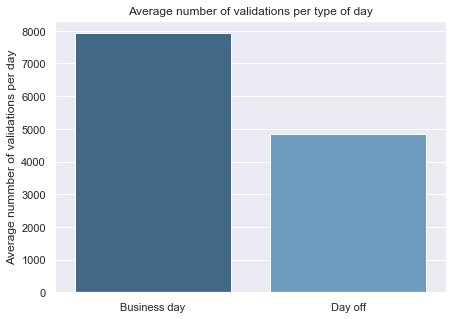

In [35]:
data_train_jour_ferie = X_train.groupby('est_jour_ferie').agg({'NB_VALD':'mean'})
plt.figure(figsize=(7,5))
index = np.arange(data_train_jour_ferie.shape[0])
ax = sns.barplot(x=index, y=data_train_jour_ferie['NB_VALD'], data=data_train_jour_ferie, palette="Blues_d")
ax = ax.set_xticklabels(["Business day","Day off"])
plt.ylabel('Average nummber of validations per day')
plt.title('Average number of validations per type of day')
plt.show()

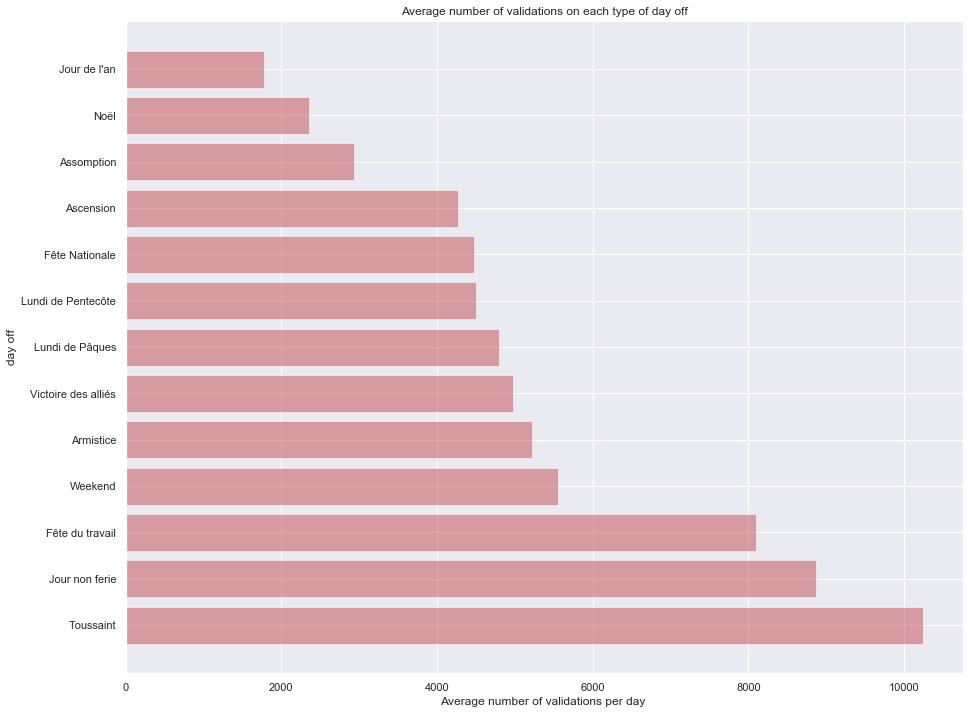

In [36]:
data_train_type_jour = X_train.groupby('type_jour').agg({'NB_VALD':'mean'})
data_train_type_jour = data_train_type_jour.sort_values(by='NB_VALD', ascending=False)

plt.figure(figsize=(15,12))
index = np.arange(data_train_type_jour.shape[0])
plt.barh(index, data_train_type_jour['NB_VALD'], alpha=0.5, color='r')
plt.yticks(range(data_train_type_jour.shape[0]), data_train_type_jour.index)
plt.ylabel('day off')
plt.xlabel('Average number of validations per day ')
plt.title('Average number of validations on each type of day off')
plt.show()

### 4.2. Number of validations per month

In [81]:
X_train.loc[X_train['NB_VALD'] == X_train['NB_VALD'].max()]

,JOUR,LIBELLE_ARRET,NB_VALD,lon,lat,res_com,mode_,principal,nb_metro,nb_rer,...,duree,type_inc,num_inc,est_greve,Jour de la semaine,Horaire en jour normal,Horaire en jour férié,est_jour_ferie,type_jour,mois
857229,2017-12-14,LA DEFENSE-GRANDE ARCHE,219051,48.891916,2.237488,LIGNE L / LIGNE U / RER A / M1 / T2,Train / RER / Metro / Tramway,1.0,1.0,1.0,...,NaN,NaN,NaN,0.0,Thursday,NaN,NaN,0,Jour non ferie,12


In [37]:
# Feature Engineering : Month
X_train['JOUR'] = pd.to_datetime(X_train['JOUR'])
X_train['mois'] = X_train['JOUR'].apply( lambda val: val.month)
X_train.head()

,JOUR,LIBELLE_ARRET,NB_VALD,lon,lat,res_com,mode_,principal,nb_metro,nb_rer,...,duree,type_inc,num_inc,est_greve,Jour de la semaine,Horaire en jour normal,Horaire en jour férié,est_jour_ferie,type_jour,mois
0,2015-01-01,ABBESSES,750,48.884505,2.338365,M12,Metro,0.0,1.0,0.0,...,NaN,NaN,NaN,0.0,Thursday,NaN,NaN,1,Jour de l'an,1
1,2015-01-01,ABLON,118,NaN,NaN,RER C,RER,0.0,0.0,1.0,...,NaN,NaN,NaN,0.0,Thursday,NaN,NaN,1,Jour de l'an,1
2,2015-01-01,ACHERES-GRAND-CORMIER,18,48.955388,2.092457,RER A,RER,0.0,0.0,1.0,...,NaN,NaN,NaN,0.0,Thursday,NaN,NaN,1,Jour de l'an,1
3,2015-01-01,ACHERES-VILLE,482,48.970248,2.077672,LIGNE L / RER A,Train / RER,0.0,0.0,1.0,...,NaN,NaN,NaN,0.0,Thursday,NaN,NaN,1,Jour de l'an,1
4,2015-01-01,AEROPORT CHARLES DE GAULLE 1,1257,49.010400,2.561357,RER B / CDGVAL,RER / Navette,0.0,0.0,1.0,...,NaN,NaN,NaN,0.0,Thursday,NaN,NaN,1,Jour de l'an,1


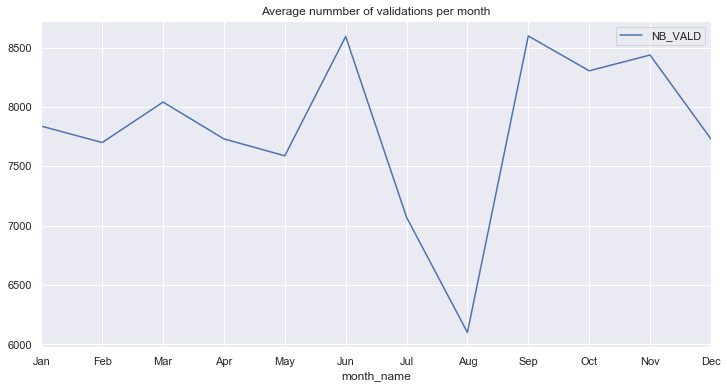

In [38]:
data_vis = X_train.copy()
data_vis['month_name'] = X_train['JOUR'].apply( lambda val: val.month)
data_vis = data_vis.groupby('month_name').agg({'NB_VALD': 'mean'}).plot(figsize=(12,6))
ticks = list(range(1, 13, 1)) # points on the x axis where labels appear
labels = 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
plt.xticks(ticks,labels)
plt.title('Average nummber of validations per month');

### 4.3. Number of validations per week_day

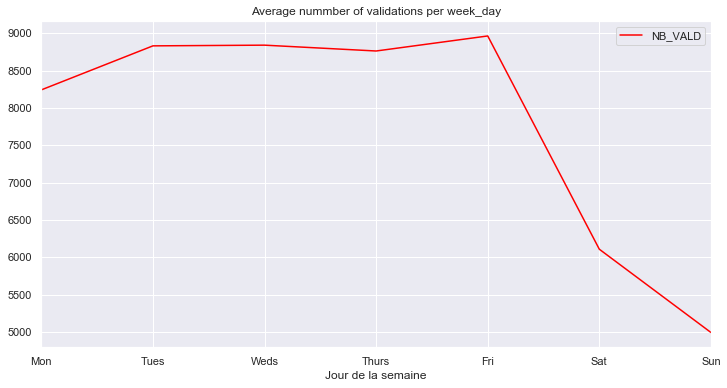

In [39]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
X_train.groupby('Jour de la semaine').agg({'NB_VALD': 'mean'}).reindex(days).plot(figsize=(12,6), color='red')
ticks = list(range(0, 7, 1)) # points on the x axis where you want the label to appear
labels = "Mon Tues Weds Thurs Fri Sat Sun".split()
plt.xticks(ticks,labels)
plt.title('Average nummber of validations per week_day');

### 4.4 .Heatmap : Number of validations per station

In [52]:
data_map.to_clipboard()

In [82]:
data_map = X_train.groupby(['JOUR','LIBELLE_ARRET']).agg({'NB_VALD': 'mean','lon':'mean','lat':'mean'}).reset_index().drop('JOUR',axis=1)
data_map['nb_valid_per_month'] = (data_map['NB_VALD'] * 30).astype(int)
data_map = data_map[pd.notnull(data_map['lon'])]
data_map.reset_index(level=0, inplace=True)
data_map.head()

,index,LIBELLE_ARRET,NB_VALD,lon,lat,nb_valid_per_month
0,0,ABBESSES,750,48.884505,2.338365,22500
1,2,ACHERES-GRAND-CORMIER,18,48.955388,2.092457,540
2,3,ACHERES-VILLE,482,48.970248,2.077672,14460
3,4,AEROPORT CHARLES DE GAULLE 1,1257,49.010400,2.561357,37710
4,5,AEROPORT CHARLES DE GAULLE 2-TGV,1832,49.004199,2.570946,54960


In [83]:
data_map.shape

(545620, 6)

In [64]:
LDN_COORDINATES = (48.8534, 2.3488)
myMap = folium.Map(location=LDN_COORDINATES, zoom_start=11)
for i in range(0,len(data_map)):
    folium.Circle(
      location=[data_map.iloc[i]['lon'], data_map.iloc[i]['lat']],
      popup= Popup('<h3>'+ str(data_map.iloc[i]['LIBELLE_ARRET']).upper() + '</h3>' + '<br>'
                 '<b> Mean_Nb_valid_per_Month: </b>' + str(data_map.iloc[i]['nb_valid_per_month']) + '<br>'
                      
                ),
      radius= data_map.iloc[i]['nb_valid_per_month'].astype(float)/5000 ,
      color='crimson',
      fill=True,
      fill_color='crimson',
        

   ).add_to(myMap)
 
display(myMap)
myMap.save(outfile= "Map.html")

KeyboardInterrupt: 

We can observe on the map that our data cover Paris and many other close cities. We remark that the number of validation is higher in center of Paris and in the station "La Défense-Grande Arche". 
As we can see below, if we click at a station, we can observe the average number of validation per month corresponding to this station.

[![map.png](https://i.postimg.cc/1Xq1th2N/map.png)](https://postimg.cc/5QbR7Gxx)

#### Top 5 stations with higher number of validations per month

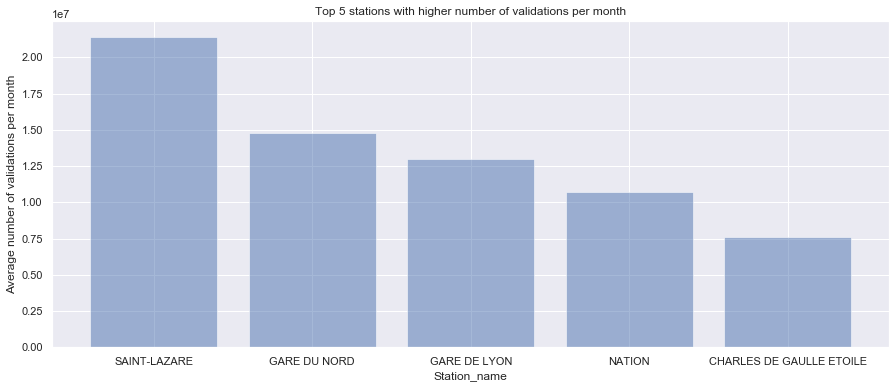

In [15]:
data_map = data_map.sort_values(by='nb_valid_per_month', ascending=False)[:5]

plt.figure(figsize=(15,6))
y_pos = np.arange(data_map.shape[0])
rects = plt.bar(y_pos, data_map['nb_valid_per_month'], align='center', alpha=0.5, color='b')
plt.xticks(y_pos, data_map['LIBELLE_ARRET'])
plt.ylabel('Average number of validations per month')
plt.xlabel('Station_name')
plt.title('Top 5 stations with higher number of validations per month')
plt.show()

### 4.5.  Validation and Stations characteristics

#### 4.5.1 . Validation average with RER number per station 

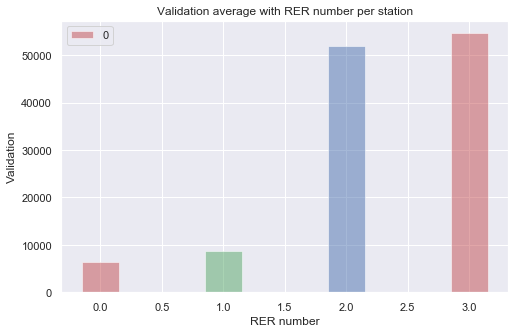

In [16]:
data_gare_vld = X_train[['NB_VALD','principal','nb_rer','nb_metro','Nbre plateformes']]

data_nb_rer = data_gare_vld.groupby('nb_rer').agg({'NB_VALD':'mean'}).reset_index()
plt.figure(figsize=(8,5))
plt.subplots_adjust(hspace=2)
index = np.arange(data_nb_rer.shape[0]).tolist()
plt.bar(index, data_nb_rer['NB_VALD'], width=0.3,alpha=0.5,color = ['r','g','b'])

plt.ylabel('Validation')
plt.xlabel('RER number')
plt.title('Validation average with RER number per station')
plt.legend(index,loc = 2)
plt.show()

#### 4.5.2.  Validation average with Metro number per station 

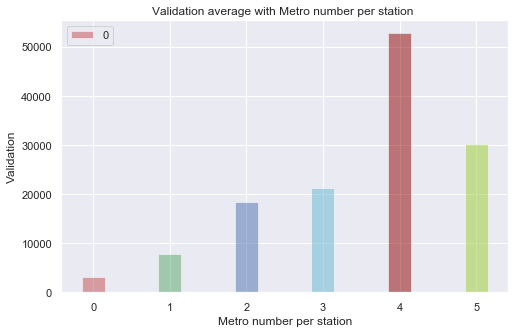

In [17]:
data_nb_metro = data_gare_vld.groupby('nb_metro').agg({'NB_VALD':'mean'})
plt.figure(figsize=(8,5))
index = np.arange(data_nb_metro.shape[0])
plt.bar(index, data_nb_metro['NB_VALD'], width=0.3,alpha=0.5, color= ['r','g','b','c','darkred','yellowgreen'])

plt.ylabel('Validation')
plt.xlabel('Metro number per station')
plt.title('Validation average with Metro number per station ')
plt.legend(index,loc = 2)
plt.show()

#### 4.5.3 . Validation average with station type

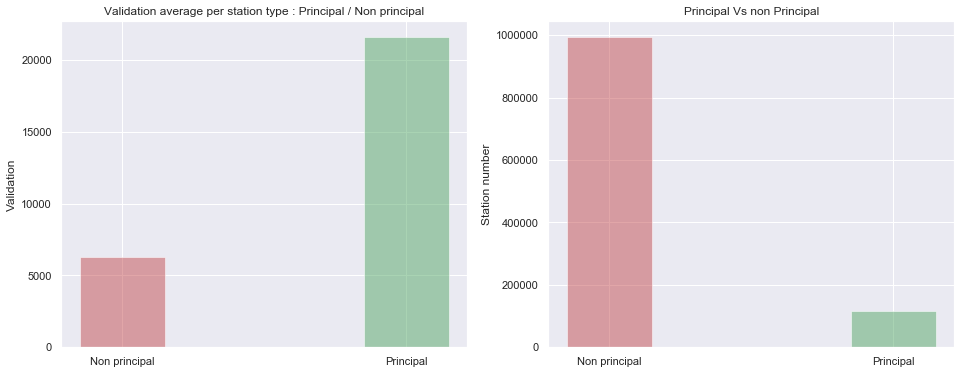

In [18]:
plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
data_principal = data_gare_vld.groupby('principal').agg({'NB_VALD':'mean'})
index = np.arange(data_principal.shape[0])
plt.bar(index, data_principal['NB_VALD'], width=0.3,alpha=0.5, color= ['r','g'])
plt.xticks([1,0],('Principal','Non principal'))
plt.ylabel('Validation')
plt.title('Validation average per station type : Principal / Non principal')

plt.subplot(1,2,2)
data_nbr_principal = data_gare_vld.groupby('principal')['principal'].count()
index = np.arange(data_nbr_principal.shape[0])
plt.bar(index, data_nbr_principal.values, width=0.3,alpha=0.5, color= ['r','g'])
plt.xticks([1,0],('Principal','Non principal'))
plt.ylabel('Station number')
plt.title('Principal Vs non Principal')
plt.show()

<a id='Prediction'></a>
## 5. Prediction

### 5.1.Feature Extractor

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline


class FeatureExtractor(object):
    def __init__(self):
        pass

    def fit(self, X_df, y_array):
        return(self)

    def transform(self, X_df):
        return self.preprocessor.transform(X_df)

### 5.2.Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator


class Regressor(BaseEstimator):
    def __init__(self):
        self.reg = RandomForestRegressor(n_estimators=5)

    def fit(self, X, y):
        self.reg.fit(X, y)

    def predict(self, X):
        return self.reg.predict(X)

<a id='Evaluation'></a>
## 6. Evaluation

<a id='Local-testing'></a>
## 7. Local Testing